<h1>Compression time series with RNN autoencoder</h1>

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler


import sys
import time
from tqdm import tqdm

# 1. Генерация Мультивариантных Данных

In [3]:
time = np.linspace(0, 10000, 100000)  # Время: от 0 до 10000, 100000 точек

# Создание трех различных сигналов
amplitude1 = np.sin(2 * np.pi * 0.1 * time)  # Синусоида 1
amplitude2 = np.sin(2 * np.pi * 0.3 * time)  # Синусоида 2
amplitude3 = np.cos(2 * np.pi * 0.3 * time)  # Косинусоида 3

# Добавление шума к каждому каналу
noise = np.random.normal(0, 0.3, size=(len(time), 3))  # 3 канала

# Итоговый мультивариантный временной ряд
signal = np.stack([amplitude1, amplitude2, amplitude3], axis=1) + noise
signal = signal.astype('float32')

In [ ]:
signal1 = pd.read_parquet('../data/part-0.parquet')
signal2 = pd.read_parquet('../data/part-1.parquet')

In [47]:
data = pd.concat([signal1, signal2], ignore_index=True)

In [48]:
print(data.dtypes)

step                    uint32
X                      float32
Y                      float32
Z                      float32
enmo                   float32
anglez                 float32
non-wear_flag          float32
light                  float32
battery_voltage        float32
time_of_day              int64
weekday                   int8
quarter                   int8
relative_date_PCIAT    float32
dtype: object


# 2. Выбор релевантных признаков


In [ ]:

# Выбираем только числовые признаки, исключая потенциально ненужные
numeric_cols = ['X', 'Y', 'Z', 'enmo', 'anglez', 'non-wear_flag', 
               'light', 'battery_voltage', 'time_of_day', 
               'weekday', 'quarter', 'relative_date_PCIAT']

# Проверяем наличие выбранных колонок
for col in numeric_cols:
    if col not in data.columns:
        raise ValueError(f"Колонка '{col}' отсутствует в данных.")

# Извлечение выбранных колонок
data = data[numeric_cols]

In [50]:
# 3. Обработка пропусков (если есть)
if data.isnull().values.any():
    print("Обнаружены пропуски в данных. Заполняем их средним значением по каждому признаку.")
    data = data.fillna(data.mean())

In [53]:
# 4. Нормализация данных

scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)


# Визуализация некоторых признаков после нормализации
def plot_multivariate_signal(signal, num_points=1000):
    num_channels = signal.shape[1]
    plt.figure(figsize=(25, 6 * num_channels))
    for i in range(num_channels):
        plt.subplot(num_channels, 1, i + 1)
        plt.plot(signal[:num_points, i], label=f"Channel {i+1}: {numeric_cols[i]}")
        plt.xlabel("Время")
        plt.ylabel("Амплитуда")
        plt.legend()
        plt.grid(True, linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

plot_multivariate_signal(data_scaled)

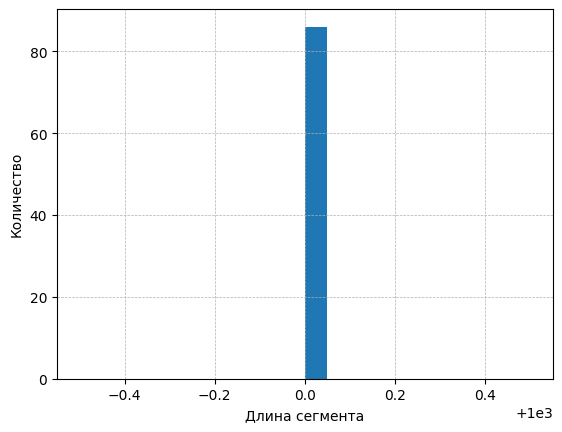

Общее количество сегментов: 86


In [56]:
# 5. Функция для разбиения на сегменты без перекрытия
def split_time_series(signal, min_length, max_length):
    """
    Разбивает временной ряд на последовательности случайной длины.
    
    Args:
        signal (np.ndarray): Входной временной ряд с формой (seq_length, num_channels).
        min_length (int): Минимальная длина сегмента.
        max_length (int): Максимальная длина сегмента.
    
    Returns:
        List[np.ndarray]: Список сегментов.
    """
    sequences = []
    i = 0
    while i < len(signal):
        segment_length = np.random.randint(min_length, max_length + 1)
        if i + segment_length > len(signal):
            break
        sequences.append(signal[i:i + segment_length])
        i += segment_length
    return sequences

sequences = split_time_series(data_scaled, min_length=1000, max_length=1000)
segments_info = [len(x) for x in sequences]

# Визуализация распределения длин сегментов
plt.hist(segments_info, bins=20)
plt.xlabel("Длина сегмента")
plt.ylabel("Количество")
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()

print(f'Общее количество сегментов: {len(sequences)}')

In [57]:
# 6. Функция для разбиения на перекрывающиеся сегменты
def split_with_overlap(sequence, window_size=60, step=1):
    """
    Разбивает последовательность на перекрывающиеся сегменты.
    
    Args:
        sequence (np.ndarray): Входная последовательность с формой (seq_length, num_channels).
        window_size (int): Размер окна (длина сегмента).
        step (int): Шаг разбиения.
    
    Returns:
        List[np.ndarray]: Список сегментов с формой (window_size, num_channels).
    """
    segments = []
    for i in range(0, len(sequence) - window_size + 1, step):
        segment = sequence[i:i + window_size]
        segments.append(segment)
    return segments


In [58]:
# 7. Класс Dataset для временных рядов
class TimeSeriesDataset(Dataset):
    def __init__(self, sequences, window_size=60, step=1):
        """
        Инициализация датасета.
    
        Args:
            sequences (List[np.ndarray]): Список временных рядов с формой (seq_length, num_channels).
            window_size (int): Размер окна для разбиения на сегменты.
            step (int): Шаг разбиения на сегменты.
        """
        self.segments = []
        for seq in sequences:
            segs = split_with_overlap(seq, window_size, step)
            self.segments.extend(segs)
    
    def __len__(self):
        return len(self.segments)
    
    def __getitem__(self, idx):
        segment = self.segments[idx]
        # Преобразуем в torch.Tensor с формой (seq_len, num_channels)
        return torch.tensor(segment, dtype=torch.float32)


In [59]:
# 8. Разделение данных на train, validation и test
train_size = int(len(sequences) * 0.7)
val_size = int(len(sequences) * 0.15)
test_size = len(sequences) - train_size - val_size

train_seqs = sequences[:train_size]
val_seqs = sequences[train_size: train_size + val_size]
test_seqs = sequences[train_size + val_size:]

print(f'train_seqs: {len(train_seqs)}, val_seqs: {len(val_seqs)}, test_seqs: {len(test_seqs)}')

train_seqs: 60, val_seqs: 12, test_seqs: 14


In [60]:
# 9. Создание датасетов
window_size = 60
step = 1
train_dataset = TimeSeriesDataset(train_seqs, window_size, step)
val_dataset = TimeSeriesDataset(val_seqs, window_size, step)
test_dataset = TimeSeriesDataset(test_seqs, window_size, step)

print(f'train_dataset: {len(train_dataset)}, val_dataset: {len(val_dataset)}, test_dataset: {len(test_dataset)}')

train_dataset: 56460, val_dataset: 11292, test_dataset: 13174


In [61]:
# 10. Создание DataLoader'ов
segment_batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=segment_batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=segment_batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=segment_batch_size, shuffle=False)

In [ ]:
# 11. Определение устройства (GPU или CPU)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Используемое устройство: {device}')

Используемое устройство: cuda


In [63]:
# 12. Определение LSTM-автоэнкодера для многомерных данных
class LSTMAutoencoder(nn.Module):
    def __init__(self, input_dim=3, hidden_dim=128, latent_dim=10, num_layers=1):
        super().__init__()
        # Encoder
        self.encoder_lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.encoder_fc = nn.Linear(hidden_dim, latent_dim)

        # Decoder
        self.decoder_fc = nn.Linear(latent_dim, hidden_dim)
        self.decoder_lstm = nn.LSTM(hidden_dim, hidden_dim, num_layers, batch_first=True)
        self.decoder_output = nn.Linear(hidden_dim, input_dim)
    
    def forward(self, x):
        # Encoder
        _, (hidden, _) = self.encoder_lstm(x)           # hidden: (num_layers, batch, hidden_dim)
        latent = self.encoder_fc(hidden[-1])            # latent: (batch, latent_dim)

        # Decoder
        decoder_hidden = self.decoder_fc(latent).unsqueeze(0)        # decoder_hidden: (num_layers, batch, hidden_dim)
        decoder_input = torch.zeros(x.size(0), x.size(1), self.decoder_lstm.input_size, device=x.device)
        decoder_output, _ = self.decoder_lstm(decoder_input, (decoder_hidden, torch.zeros_like(decoder_hidden)))
        output = self.decoder_output(decoder_output)                 # (batch, seq_len, input_dim)

        return output, latent

In [65]:
# 13. Инициализация модели
num_features = data_scaled.shape[1]  # Количество каналов, например, 3
hidden_dim = 128
latent_dim = 30

model = LSTMAutoencoder(input_dim=num_features, hidden_dim=hidden_dim, latent_dim=latent_dim)
model = model.to(device)

In [67]:
# 14. Определение функции потерь и оптимизатора 
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

print(model)
# Пример прохождения через модель
tensor = next(iter(train_loader))
print(f'Форма входных данных: {tensor.shape}')  # Ожидается (batch_size, window_size, num_channels)
tensor = tensor.to(device)
reconstructed, latent = model(tensor)
print(f'Форма реконструированных данных: {reconstructed.shape}, Форма латентных представлений: {latent.shape}')
# Ожидается (batch_size, window_size, num_channels) и (batch_size, latent_dim)

LSTMAutoencoder(
  (encoder_lstm): LSTM(12, 128, batch_first=True)
  (encoder_fc): Linear(in_features=128, out_features=30, bias=True)
  (decoder_fc): Linear(in_features=30, out_features=128, bias=True)
  (decoder_lstm): LSTM(128, 128, batch_first=True)
  (decoder_output): Linear(in_features=128, out_features=12, bias=True)
)
Форма входных данных: torch.Size([64, 60, 12])
Форма реконструированных данных: torch.Size([64, 60, 12]), Форма латентных представлений: torch.Size([64, 30])


In [68]:
# 15. Обучение модели
num_epochs = 2

for epoch in range(num_epochs):
    model.train()       # Переход в режим обучения
    train_loss = 0.0    # Суммарная потеря на обучающей выборке

    # Progress bar для обучения
    train_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} - Training', leave=False, file=sys.stdout)

    for batch in train_bar:
        batch = batch.to(device)        # (batch_size, window_size, num_channels)
        optimizer.zero_grad()
        reconstructed, latent = model(batch)
        loss = criterion(reconstructed, batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * batch.size(0)

        # Обновление прогресса в tqdm
        train_bar.set_postfix({'Batch Loss': loss.item()})

    avg_train_loss = train_loss / len(train_loader.dataset)

    # Валидация
    model.eval()    # Переход в режим оценки
    val_loss = 0.0    # Суммарная потеря на валидационной выборке

    val_bar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} - Validation', leave=False, file=sys.stdout)

    with torch.no_grad():
        for batch in val_bar:
            batch = batch.to(device)
            reconstructed, latent = model(batch)
            loss = criterion(reconstructed, batch)
            val_loss += loss.item() * batch.size(0)

            # Обновление прогресса в tqdm
            val_bar.set_postfix({'Batch Loss': loss.item()})

    avg_val_loss = val_loss / len(val_loader.dataset)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}')


Epoch [1/2], Train Loss: 0.577908, Val Loss: 0.503038                                      
Epoch [2/2], Train Loss: 0.502744, Val Loss: 0.585367                                       


In [69]:
# 16. Оценка на тестовой выборке
model.eval()  # Переход в режим оценки
test_loss = 0.0  # Суммарная потеря на тестовой выборке
test_bar = tqdm(test_loader, desc='Testing', leave=False)

with torch.no_grad():
    for batch in test_bar:
        batch = batch.to(device)  # Перемещение данных на устройство
        reconstructed, latent = model(batch)  # Прямой проход через модель
        loss = criterion(reconstructed, batch)  # Вычисление потерь
        test_loss += loss.item() * batch.size(0)  # Суммирование потерь

        # Обновление прогресса в tqdm
        test_bar.set_postfix({'Batch Loss': loss.item()})

avg_test_loss = test_loss / len(test_loader.dataset)  # Средняя потеря на тестовой выборке
print(f'Test Loss: {avg_test_loss:.6f}')

Test Loss: 0.495851


In [70]:
# 17. Функция для получения латентных представлений для полной последовательности
def get_latent_representations(model, sequence, window_size=60, step=1, segment_batch_size=64):
    """
    Получает усредненные латентные представления для полной последовательности.
    
    Args:
        model (nn.Module): Обученная модель автоэнкодера.
        sequence (numpy.ndarray): Исходная последовательность с формой (seq_length, num_channels).
        window_size (int): Размер окна для разбиения на сегменты.
        step (int): Шаг разбиения на сегменты.
        segment_batch_size (int): Размер батча для обработки сегментов.
    
    Returns:
        numpy.ndarray: Усредненное латентное представление всей последовательности.
    """
    model.eval()
    segments = split_with_overlap(sequence, window_size, step)
    # Преобразуем сегменты в тензоры
    segments = [torch.tensor(seg, dtype=torch.float32) for seg in segments]  # (window_size, num_channels)

    # Создание DataLoader для сегментов
    dataloader = DataLoader(segments, batch_size=segment_batch_size, shuffle=False)

    latent_vectors = []
    with torch.no_grad():
        for batch in tqdm(dataloader, desc='Extracting Latent Vectors', leave=False):
            batch = batch.to(device)  # (batch_size, window_size, num_channels)
            _, latent = model(batch)   # latent: (batch_size, latent_dim)
            latent_vectors.append(latent.cpu().numpy())

    # Объединяем все латентные векторы
    latent_vectors = np.concatenate(latent_vectors, axis=0)  # (num_segments, latent_dim)
    return np.mean(latent_vectors, axis=0)  # Усреднение латентных векторов

In [86]:
get_latent_representations(model, test_seqs[0], window_size=60, step=1, segment_batch_size=64)

Extracting Latent Vectors:   0%|          | 0/15 [00:00<?, ?it/s]

array([ 0.979026  ,  1.7952316 , -3.6770482 , -2.6386147 ,  1.4282699 ,
       -0.41073704, -0.71989286, -0.39312214, -1.6488819 ,  0.18901712,
        0.24921973,  0.9067115 , -2.2828608 ,  2.0349698 , -1.002622  ,
        1.2122136 , -0.3162386 ,  0.8475082 ,  0.34884158, -1.7507914 ,
        0.78618413,  1.1937659 ,  1.817218  ,  1.1170082 , -1.2114145 ,
        0.16221598, -1.0077374 ,  0.83791816,  0.9287946 ,  0.58527195],
      dtype=float32)

In [71]:
# 18. Функция для восстановления полной последовательности
def reconstruct_sequence(model, sequence, window_size=60, step=1, segment_batch_size=64):
    """
    Восстанавливает полную последовательность из реконструированных сегментов.
    
    Args:
        model (nn.Module): Обученная модель автоэнкодера.
        sequence (numpy.ndarray): Исходная последовательность с формой (seq_length, num_channels).
        window_size (int): Размер окна для разбиения на сегменты.
        step (int): Шаг разбиения на сегменты.
        segment_batch_size (int): Размер батча для обработки сегментов.
    
    Returns:
        numpy.ndarray: Восстановленная последовательность с формой (seq_length, num_channels).
    """
    model.eval()  # Переход в режим оценки
    segments = split_with_overlap(sequence, window_size, step)
    # Преобразуем сегменты в тензоры
    segments = [torch.tensor(seg, dtype=torch.float32) for seg in segments]  # (window_size, num_channels)

    # Создание DataLoader для сегментов
    dataloader = DataLoader(segments, batch_size=segment_batch_size, shuffle=False)

    reconstructed_segments = []
    with torch.no_grad():
        for batch in tqdm(dataloader, desc='Reconstructing Segments', leave=False):
            batch = batch.to(device)  # (batch_size, window_size, num_channels)
            reconstructed, _ = model(batch)  # (batch_size, window_size, num_channels)
            reconstructed_segments.append(reconstructed.cpu().numpy())

    # Объединяем все реконструированные сегменты
    reconstructed_segments = np.concatenate(reconstructed_segments, axis=0)  # (num_segments, window_size, num_channels)

    # Инициализация массивов для суммирования и подсчёта перекрытий
    num_channels = sequence.shape[1]
    total_length = len(sequence)
    reconstructed_sequence = np.zeros((total_length, num_channels), dtype=np.float32)
    count = np.zeros((total_length, num_channels), dtype=np.float32)

    for i, seg in enumerate(reconstructed_segments):
        start = i * step
        end = start + window_size
        if end > total_length:
            end = total_length
            seg = seg[:end - start, :]  # Корректировка размера сегмента, если он выходит за пределы последовательности
        reconstructed_sequence[start:end, :] += seg[:end - start, :]
        count[start:end, :] += 1.0

    # Усреднение значений в местах перекрытия
    reconstructed_sequence /= count
    return reconstructed_sequence


In [72]:
# 19. Функция для оценки качества реконструкции
def evaluate_reconstruction(model, test_sequences, window_size=60, step=1, segment_batch_size=64):
    """
    Восстанавливает и оценивает качество реконструкции для тестовых последовательностей.
    
    Args:
        model (nn.Module): Обученная модель автоэнкодера.
        test_sequences (List[np.ndarray]): Список тестовых последовательностей с формой (seq_length, num_channels).
        window_size (int): Размер окна для разбиения на сегменты.
        step (int): Шаг разбиения на сегменты.
        segment_batch_size (int): Размер батча для обработки сегментов.
    
    Returns:
        float: Среднее значение MSE на тестовой выборке.
    """
    mse_total = 0.0  # Суммарное значение MSE
    num_elements = 0  # Общее количество элементов

    for seq in tqdm(test_sequences, desc='Reconstructing Sequences'):
        reconstructed_seq = reconstruct_sequence(model, seq, window_size, step, segment_batch_size)
        mse = np.mean((reconstructed_seq - seq) ** 2)
        mse_total += mse * len(seq)
        num_elements += len(seq)

    avg_mse = mse_total / num_elements
    return avg_mse

In [73]:
# 20. Оценка качества реконструкции на тестовой выборке
test_reconstruction_mse = evaluate_reconstruction(model, test_seqs, window_size, step, segment_batch_size)
print(f'Test Reconstruction MSE: {test_reconstruction_mse:.6f}')

Reconstructing Sequences: 100%|██████████| 14/14 [00:02<00:00,  6.53it/s]

Test Reconstruction MSE: 0.482180


In [74]:
# 21. Функция для восстановления всех тестовых последовательностей
def restore_test_sequences(model, test_sequences, window_size=60, step=1, segment_batch_size=64):
    """
    Восстанавливает все тестовые последовательности.
    
    Args:
        model (nn.Module): Обученная модель автоэнкодера.
        test_sequences (List[np.ndarray]): Список тестовых последовательностей с формой (seq_length, num_channels).
        window_size (int): Размер окна для разбиения на сегменты.
        step (int): Шаг разбиения на сегменты.
        segment_batch_size (int): Размер батча для обработки сегментов.
    
    Returns:
        List[np.ndarray]: Список восстановленных последовательностей с формой (seq_length, num_channels).
    """
    reconstructed_sequences = []
    for seq in tqdm(test_sequences, desc='Restoring Sequences'):
        reconstructed_seq = reconstruct_sequence(model, seq, window_size, step, segment_batch_size)
        reconstructed_sequences.append(reconstructed_seq)
    return reconstructed_sequences


In [75]:
# 22. Восстановление всех тестовых последовательностей
restored_test_sequences = restore_test_sequences(model, test_seqs, window_size, step, segment_batch_size)

Restoring Sequences: 100%|██████████| 14/14 [00:02<00:00,  6.17it/s]


In [76]:
# 23. Функция для визуализации реконструкции
def plot_reconstruction_multivariate(original, reconstructed, index=0):
    """
    Строит графики оригинальной и восстановленной мультивариантной последовательности.
    
    Args:
        original (numpy.ndarray): Оригинальная последовательность (seq_length, num_channels).
        reconstructed (numpy.ndarray): Восстановленная последовательность (seq_length, num_channels).
        index (int): Индекс последовательности для отображения.
    """
    num_channels = original.shape[1]
    plt.figure(figsize=(25, 6 * num_channels))
    
    for i in range(num_channels):
        plt.subplot(num_channels, 1, i + 1)
        plt.plot(original[:, i], label=f'Original Channel {i+1}: {numeric_cols[i]}', linewidth=1)
        plt.plot(reconstructed[:, i], label=f'Reconstructed Channel {i+1}: {numeric_cols[i]}', linewidth=1, alpha=0.7)
        plt.legend()
        plt.xlabel('Время')
        plt.ylabel('Амплитуда')
        plt.grid(True, linestyle='--', linewidth=0.5)
    
    plt.tight_layout()
    plt.show()


In [77]:
# 24. Визуализация первой тестовой последовательности
if len(restored_test_sequences) > 0:
    # Индекс последовательности можно выбрать по желанию
    test_index = 0  # Можно изменить на 0..len(restored_test_sequences)-1
    plot_reconstruction_multivariate(test_seqs[test_index], restored_test_sequences[test_index], index=test_index)

# Дополнительно: Функция для получения латентных представлений (опционально)
def get_latent_representations(model, sequence, window_size=60, step=1, segment_batch_size=64):
    """
    Получает усредненные латентные представления для полной последовательности.
    
    Args:
        model (nn.Module): Обученная модель автоэнкодера.
        sequence (numpy.ndarray): Исходная последовательность с формой (seq_length, num_channels).
        window_size (int): Размер окна для разбиения на сегменты.
        step (int): Шаг разбиения на сегменты.
        segment_batch_size (int): Размер батча для обработки сегментов.
    
    Returns:
        numpy.ndarray: Усредненное латентное представление всей последовательности.
    """
    model.eval()
    segments = split_with_overlap(sequence, window_size, step)
    # Преобразуем сегменты в тензоры
    segments = [torch.tensor(seg, dtype=torch.float32) for seg in segments]  # (window_size, num_channels)

    # Создание DataLoader для сегментов
    dataloader = DataLoader(segments, batch_size=segment_batch_size, shuffle=False)

    latent_vectors = []
    with torch.no_grad():
        for batch in tqdm(dataloader, desc='Extracting Latent Vectors', leave=False):
            batch = batch.to(device)  # (batch_size, window_size, num_channels)
            _, latent = model(batch)   # latent: (batch_size, latent_dim)
            latent_vectors.append(latent.cpu().numpy())

    # Объединяем все латентные векторы
    latent_vectors = np.concatenate(latent_vectors, axis=0)  # (num_segments, latent_dim)
    return np.mean(latent_vectors, axis=0)  # Усреднение латентных векторов

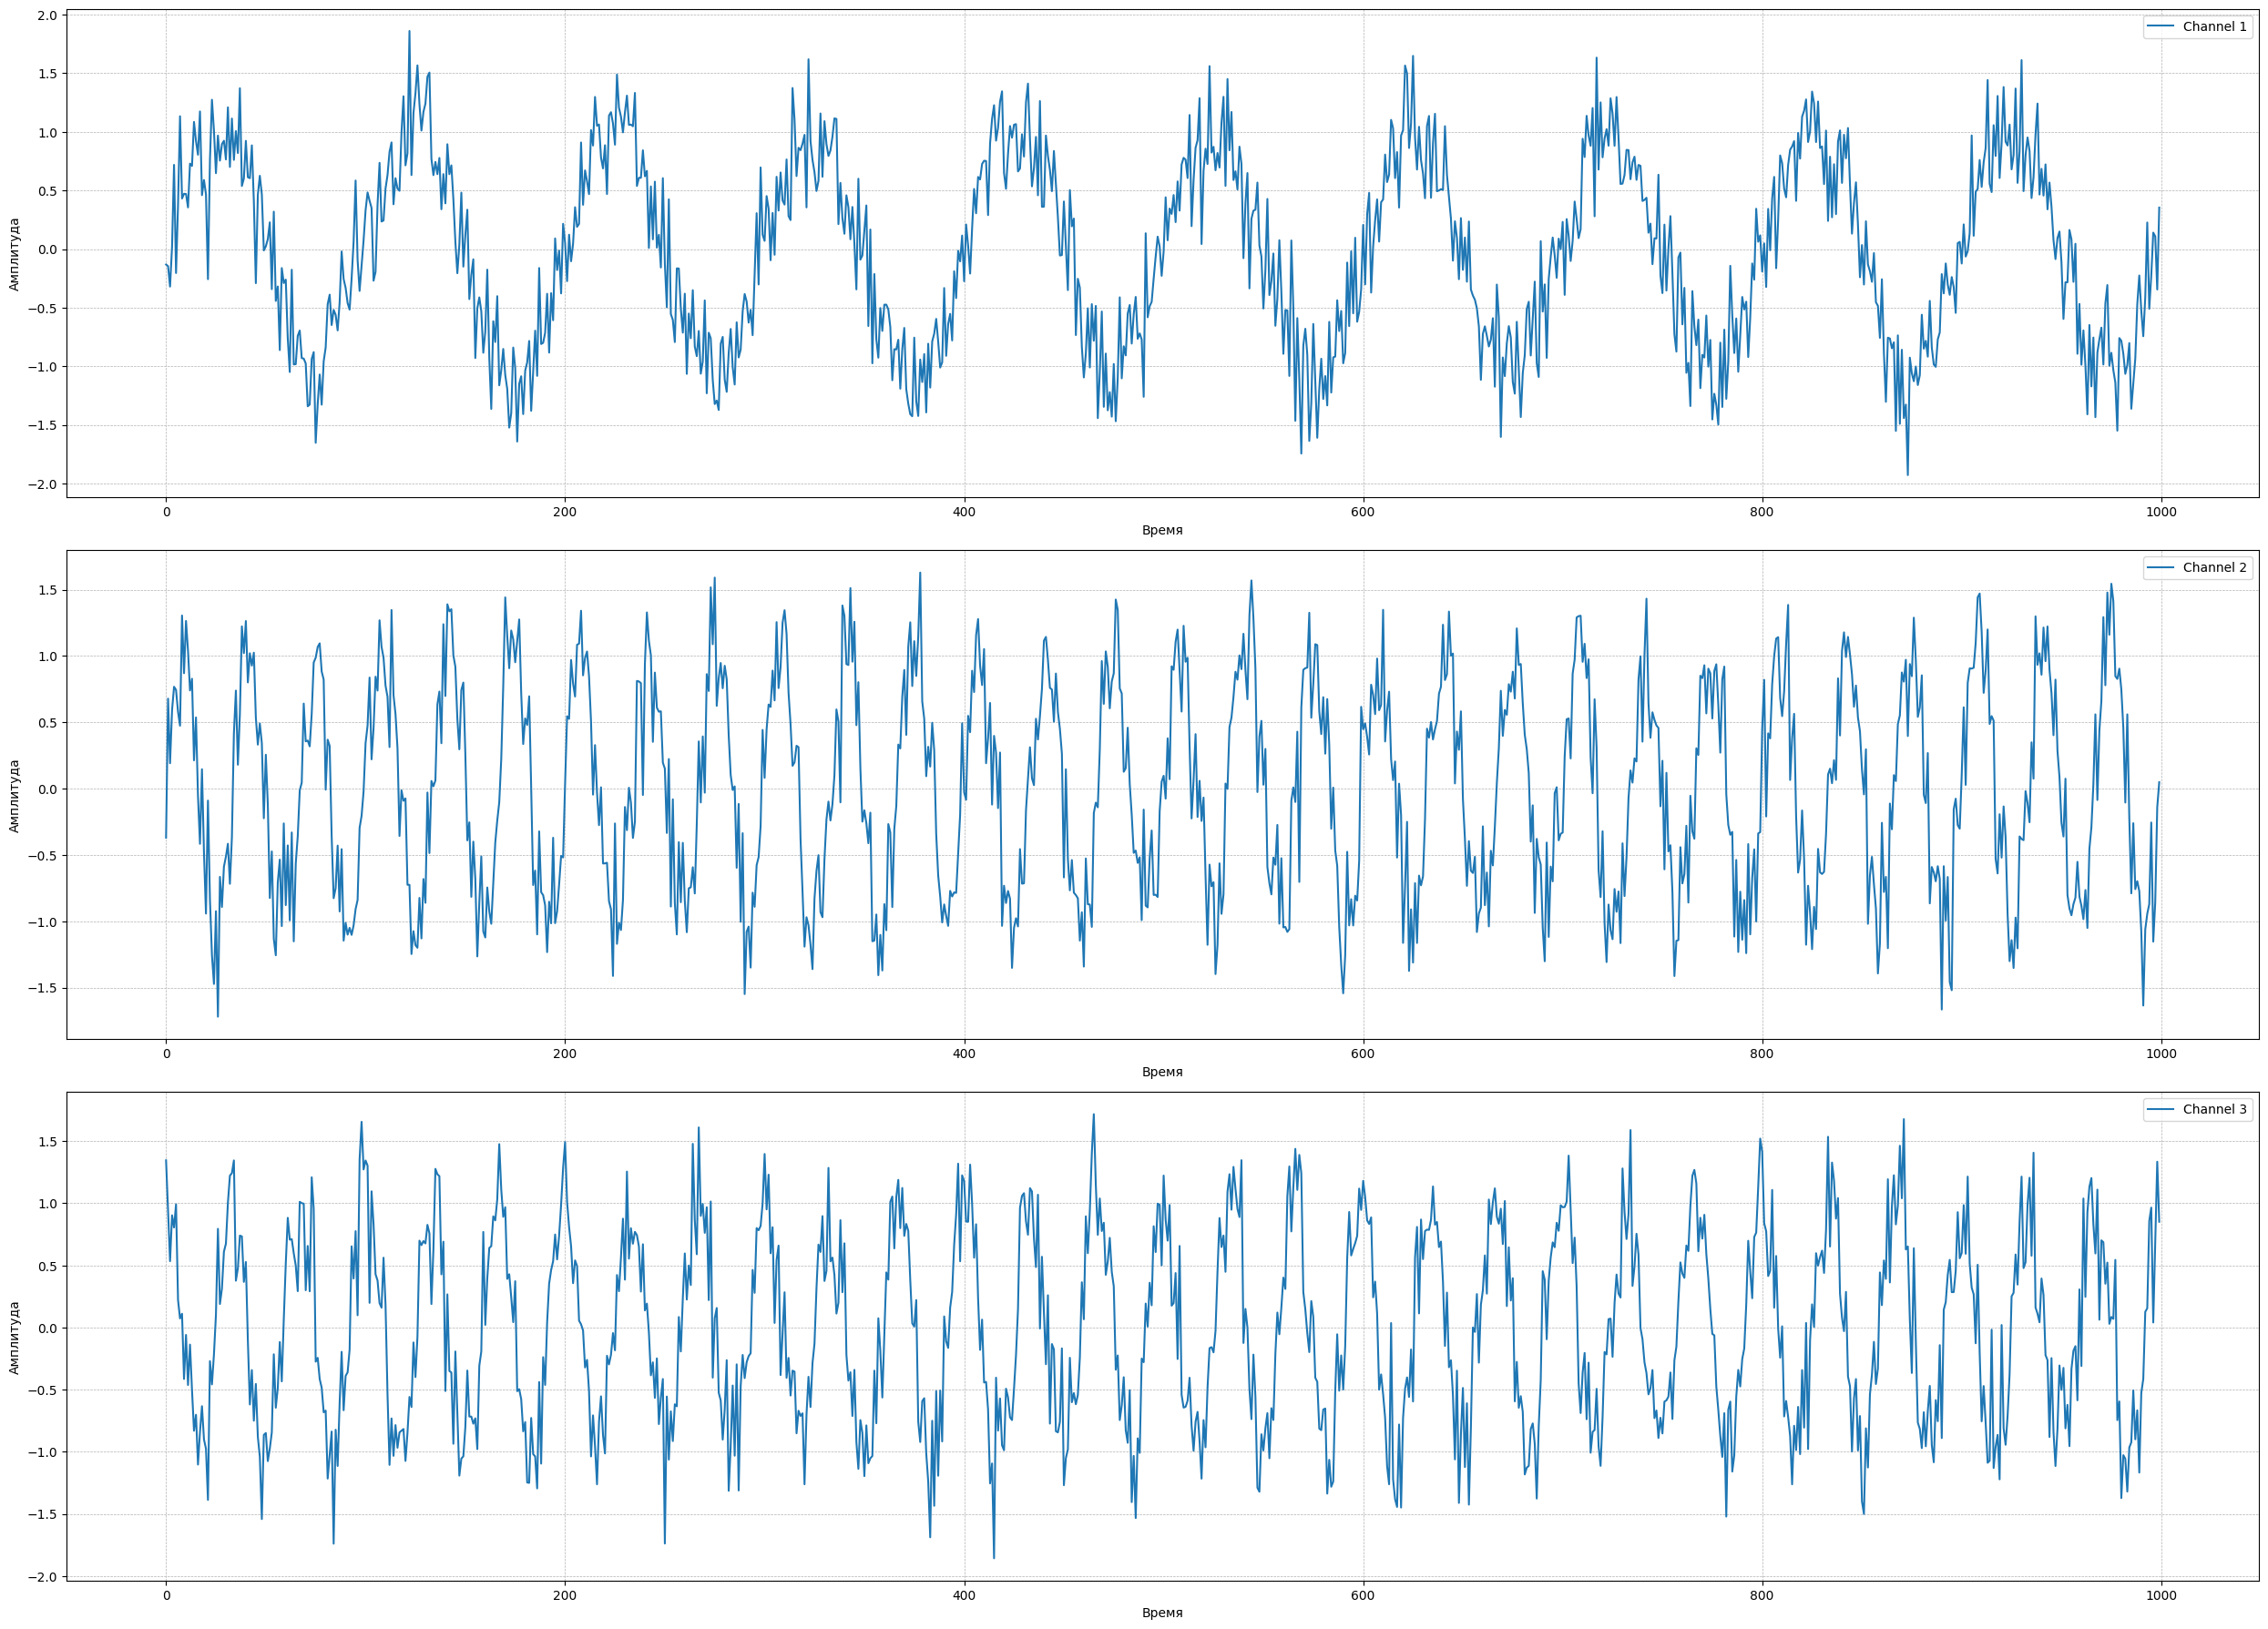

In [4]:
# Визуализация первых 1000 точек для каждого канала
def plot_multivariate_signal(signal, num_points=1000):
    num_channels = signal.shape[1]
    plt.figure(figsize=(25, 6 * num_channels))
    for i in range(num_channels):
        plt.subplot(num_channels, 1, i + 1)
        plt.plot(signal[:num_points, i], label=f"Channel {i+1}")
        plt.xlabel("Время")
        plt.ylabel("Амплитуда")
        plt.legend()
        plt.grid(True, linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

plot_multivariate_signal(signal)

# 2. Функция для разбиения на сегменты без перекрытия

In [5]:
# 2. Функция для разбиения на сегменты без перекрытия
def split_time_series(signal, min_length, max_length):
    segments = []
    i = 0
    while i < len(signal):
        segment_length = np.random.randint(min_length, max_length + 1)
        if i + segment_length > len(signal):
            break
        segments.append(signal[i:i + segment_length])
        i += segment_length
    return segments

sequences = split_time_series(signal, min_length=600, max_length=900)

Общее количество сегментов: 133


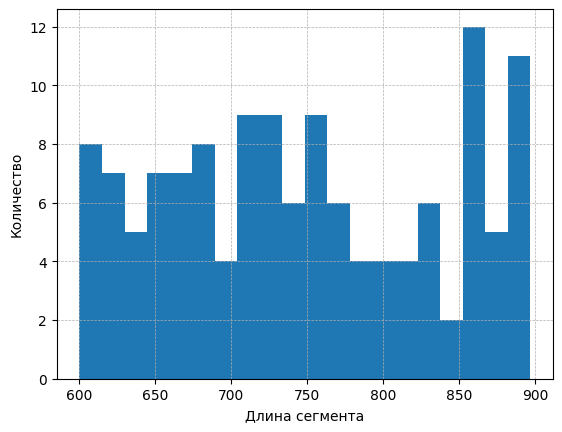

In [8]:
segments_info = [len(x) for x in sequences]
print(f'Общее количество сегментов: {len(sequences)}')

# Визуализация распределения длин сегментов
plt.hist(segments_info, bins=20)
plt.xlabel("Длина сегмента")
plt.ylabel("Количество")
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()

# 3. Функция для разбиения на перекрывающиеся сегменты

In [9]:
def split_with_overlap(sequence, window_size=60, step=1):
    '''
    Split sequence on overlapping segments

    Args:
        sequence (np.ndarray): Input sequence with shape (seq_length, num_channels)
        window_size (int): Window size (segment length)
        step (int): Split step
    
    Returns:
        List[np.ndarray]: List of segments with shape (window_size, num_channels)
    '''
    segments = []
    for i in range(0, len(sequence) - window_size + 1, step):
        segment = sequence[i:i + window_size]
        segments.append(segment)
    return segments

# 4. Класс Dataset для временных рядов

In [10]:
class TimeSeriesDataset(Dataset):
    def __init__(self, sequences, window_size=60, step=1):
        '''
        Dataset initialization

        Args:
            sequences (List[np.ndarray]): List of time series with shape (seq_length, num_channels)
            window_size (int): Window size (segment length)
            step (int): Split step
        '''
        self.segments = []
        for seq in sequences:
            segs = split_with_overlap(seq, window_size, step)
            self.segments.extend(segs)
        
    def __len__(self):
        return len(self.segments)

    def __getitem__(self, idx):
        segment = self.segments[idx]
        # Преобразуем в torch.Tensor с формой (seq_len, num_channels)
        return torch.tensor(segment, dtype=torch.float32)

# 5. Разделение данных на train, validation и test

In [ ]:
train_size = int(len(sequences) * 0.7)
val_size = int(len(sequences) * 0.15)

train_seqs = sequences[:train_size]
val_seqs = sequences[train_size: train_size + val_size]
test_seqs = sequences[train_size + val_size:]

print(f'train_seqs: {len(train_seqs)}, val_seqs: {len(val_seqs)}, test_seqs: {len(test_seqs)}')

train_seqs: 93, val_seqs: 19, test_seqs: 21


# 6. Создание датасетов

In [12]:
window_size = 60
step = 1
train_dataset = TimeSeriesDataset(train_seqs, window_size, step)
val_dataset = TimeSeriesDataset(val_seqs, window_size, step)
test_dataset = TimeSeriesDataset(test_seqs, window_size, step)

print(f'train_dataset: {len(train_dataset)}, val_dataset: {len(val_dataset)}, test_dataset: {len(test_dataset)}')

train_dataset: 63644, val_dataset: 13051, test_dataset: 14882


# 7. Создание DataLoader'ов

In [ ]:
segment_batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=segment_batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=segment_batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=segment_batch_size, shuffle=False)

# 8. Определение устройства (GPU или CPU)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Используемое устройство: {device}')

Используемое устройство: cuda


# 9. Определение LSTM-автоэнкодера для многомерных данных

In [14]:
class LSTMAutoencoder(nn.Module):
    def __init__(self, input_dim=3, hidden_dim=128, latent_dim=10, num_layers=1):
        super().__init__()
        # Encoder
        self.encoder_lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.encoder_fc = nn.Linear(hidden_dim, latent_dim)

        # Decoder
        self.decoder_fc = nn.Linear(latent_dim, hidden_dim)
        self.decoder_lstm = nn.LSTM(hidden_dim, hidden_dim, num_layers, batch_first=True)
        self.decoder_output = nn.Linear(hidden_dim, input_dim)
    
    def forward(self, x):
        # Encoder
        _, (hidden, _) = self.encoder_lstm(x)           # hidden: (num_layers, batch, hidden_dim)
        latent = self.encoder_fc(hidden[-1])            # latent: (batch, latent_dim)

        # Decoder
        decoder_hidden = self.decoder_fc(latent).unsqueeze(0)        # decoder_hidden: (num_layers, batch, hidden_dim)
        decoder_input = torch.zeros(x.size(0), x.size(1), self.decoder_lstm.input_size, device=x.device)
        decoder_output, _ = self.decoder_lstm(decoder_input, (decoder_hidden, torch.zeros_like(decoder_hidden)))
        output = self.decoder_output(decoder_output)                 # (batch, seq_len, input_dim)

        return output, latent


# 10. Инициализация модели

In [15]:
num_features = 3  # Количество каналов
hidden_dim = 128
latent_dim = 10

model = LSTMAutoencoder(input_dim=num_features, hidden_dim=hidden_dim, latent_dim=latent_dim)
model = model.to(device)

# 11. Определение функции потерь и оптимизатора 


In [ ]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

print(model)

# Пример прохождения через модель
tensor = next(iter(train_loader))
print(f'Форма входных данных: {tensor.shape}')  # Ожидается (batch_size, seq_len, num_channels)
tensor = tensor.to(device)
reconstructed, latent = model(tensor)
print(f'Форма реконструированных данных: {reconstructed.shape}, Форма латентных представлений: {latent.shape}')
# Ожидается (batch_size, seq_len, num_channels) и (batch_size, latent_dim)

LSTMAutoencoder(
  (encoder_lstm): LSTM(3, 128, batch_first=True)
  (encoder_fc): Linear(in_features=128, out_features=10, bias=True)
  (decoder_fc): Linear(in_features=10, out_features=128, bias=True)
  (decoder_lstm): LSTM(128, 128, batch_first=True)
  (decoder_output): Linear(in_features=128, out_features=3, bias=True)
)
Форма входных данных: torch.Size([64, 60, 3])
Форма реконструированных данных: torch.Size([64, 60, 3]), Форма латентных представлений: torch.Size([64, 10])


# 12. Обучение модели

In [17]:
num_epochs = 5

for epoch in range(num_epochs):
    model.train()       # Переход в режим обучения
    train_loss = 0.0    # Суммарная потеря на обучающей выборке

    # Progress bar для обучения
    train_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} - Training', leave=False, file=sys.stdout)

    for batch in train_bar:
        batch = batch.to(device)        # (batch_size, window_size, num_channels)
        optimizer.zero_grad()
        reconstructed, latent = model(batch)
        loss = criterion(reconstructed, batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * batch.size(0)

        # Обновление прогресса в tqdm
        train_bar.set_postfix({'Batch Loss': loss.item()})

    avg_train_loss = train_loss / len(train_loader.dataset)

    # Валидация
    model.eval()    # Переход в режим оценки
    val_loss = 0.0    # Суммарная потеря на валидационной выборке

    val_bar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} - Validation', leave=False, file=sys.stdout)

    with torch.no_grad():
        for batch in val_bar:
            batch = batch.to(device)
            reconstructed, latent = model(batch)
            loss = criterion(reconstructed, batch)
            val_loss += loss.item() * batch.size(0)

            # Обновление прогресса в tqdm
            val_bar.set_postfix({'Batch Loss': loss.item()})

    avg_val_loss = val_loss / len(val_loader.dataset)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}')


Epoch [1/5], Train Loss: 0.149220, Val Loss: 0.090762                                        
Epoch [2/5], Train Loss: 0.090086, Val Loss: 0.090304                                        
Epoch [3/5], Train Loss: 0.090003, Val Loss: 0.090938                                        
Epoch [4/5], Train Loss: 0.089948, Val Loss: 0.090215                                       
Epoch [5/5], Train Loss: 0.089977, Val Loss: 0.090581                                        


# 13. Оценка на тестовой выборке

In [18]:
model.eval()  # Переход в режим оценки
test_loss = 0.0  # Суммарная потеря на тестовой выборке
test_bar = tqdm(test_loader, desc='Testing', leave=False)

with torch.no_grad():
    for batch in test_bar:
        batch = batch.to(device)  # Перемещение данных на устройство
        reconstructed, latent = model(batch)  # Прямой проход через модель
        loss = criterion(reconstructed, batch)  # Вычисление потерь
        test_loss += loss.item() * batch.size(0)  # Суммирование потерь

        # Обновление прогресса в tqdm
        test_bar.set_postfix({'Batch Loss': loss.item()})

avg_test_loss = test_loss / len(test_loader.dataset)  # Средняя потеря на тестовой выборке
print(f'Test Loss: {avg_test_loss:.6f}')

Test Loss: 0.089820


# 14. Функция для получения латентных представлений для полной последовательности

In [19]:
def get_latent_representations(model, sequence, window_size=60, step=1, segment_batch_size=64):
    """
    Получает латентные представления для полной последовательности.

    Args:
        model (nn.Module): Обученная модель автоэнкодера.
        sequence (numpy.ndarray): Исходная последовательность с формой (seq_length, num_channels).
        window_size (int): Размер окна для разбиения на сегменты.
        step (int): Шаг разбиения на сегменты.
        segment_batch_size (int): Размер батча для обработки сегментов.

    Returns:
        numpy.ndarray: Усредненное латентное представление всей последовательности.
    """
    model.eval()
    segments = split_with_overlap(sequence, window_size, step)
    # Преобразуем сегменты в тензоры
    segments = [torch.tensor(seg, dtype=torch.float32) for seg in segments]  # (window_size, num_channels)

    # Создание DataLoader для сегментов
    dataloader = DataLoader(segments, batch_size=segment_batch_size, shuffle=False)

    latent_vectors = []
    with torch.no_grad():
        for batch in tqdm(dataloader, desc='Extracting Latent Vectors', leave=False):
            batch = batch.to(device)  # (batch_size, window_size, num_channels)
            _, latent = model(batch)   # latent: (batch_size, latent_dim)
            latent_vectors.append(latent.cpu().numpy())

    # Объединяем все латентные векторы
    latent_vectors = np.concatenate(latent_vectors, axis=0)  # (num_segments, latent_dim)
    return np.mean(latent_vectors, axis=0)  # Усреднение латентных векторов

In [29]:
sequences[0].shape

(759, 3)

In [31]:
out = get_latent_representations(model, sequences[0], window_size=60, step=1, segment_batch_size=64)
out.shape

(10,)

# 15. Функция для восстановления полной последовательности


In [20]:
def reconstruct_sequence(model, sequence, window_size=60, step=1, segment_batch_size=64):
    """
    Восстанавливает полную последовательность из реконструированных сегментов.

    Args:
        model (nn.Module): Обученная модель автоэнкодера.
        sequence (numpy.ndarray): Исходная последовательность с формой (seq_length, num_channels).
        window_size (int): Размер окна для разбиения на сегменты.
        step (int): Шаг разбиения на сегменты.
        segment_batch_size (int): Размер батча для обработки сегментов.

    Returns:
        numpy.ndarray: Восстановленная последовательность с формой (seq_length, num_channels).
    """
    model.eval()  # Переход в режим оценки
    segments = split_with_overlap(sequence, window_size, step)
    # Преобразуем сегменты в тензоры
    segments = [torch.tensor(seg, dtype=torch.float32) for seg in segments]  # (window_size, num_channels)

    # Создание DataLoader для сегментов
    dataloader = DataLoader(segments, batch_size=segment_batch_size, shuffle=False)

    reconstructed_segments = []
    with torch.no_grad():
        for batch in tqdm(dataloader, desc='Reconstructing Segments', leave=False):
            batch = batch.to(device)  # (batch_size, window_size, num_channels)
            reconstructed, _ = model(batch)  # (batch_size, window_size, num_channels)
            reconstructed_segments.append(reconstructed.cpu().numpy())

    # Объединяем все реконструированные сегменты
    reconstructed_segments = np.concatenate(reconstructed_segments, axis=0)  # (num_segments, window_size, num_channels)

    # Инициализация массивов для суммирования и подсчёта перекрытий
    num_channels = sequence.shape[1]
    total_length = len(sequence)
    reconstructed_sequence = np.zeros((total_length, num_channels), dtype=np.float32)
    count = np.zeros((total_length, num_channels), dtype=np.float32)

    for i, seg in enumerate(reconstructed_segments):
        start = i * step
        end = start + window_size
        if end > total_length:
            end = total_length
            seg = seg[:end - start, :]  # Корректировка размера сегмента, если он выходит за пределы последовательности
        reconstructed_sequence[start:end, :] += seg[:end - start, :]
        count[start:end, :] += 1.0

    # Усреднение значений в местах перекрытия
    reconstructed_sequence /= count
    return reconstructed_sequence

# 16. Функция для оценки качества реконструкции

In [21]:
def evaluate_reconstruction(model, test_sequences, window_size=60, step=1, segment_batch_size=64):
    """
    Восстанавливает и оценивает качество реконструкции для тестовых последовательностей.

    Args:
        model (nn.Module): Обученная модель автоэнкодера.
        test_sequences (List[np.ndarray]): Список тестовых последовательностей с формой (seq_length, num_channels).
        window_size (int): Размер окна для разбиения на сегменты.
        step (int): Шаг разбиения на сегменты.
        segment_batch_size (int): Размер батча для обработки сегментов.

    Returns:
        float: Среднее значение MSE на тестовой выборке.
    """
    mse_total = 0.0  # Суммарное значение MSE
    num_elements = 0  # Общее количество элементов

    for seq in tqdm(test_sequences, desc='Reconstructing Sequences'):
        reconstructed_seq = reconstruct_sequence(model, seq, window_size, step, segment_batch_size)
        mse = np.mean((reconstructed_seq - seq) ** 2)
        mse_total += mse * len(seq)
        num_elements += len(seq)

    avg_mse = mse_total / num_elements
    return avg_mse


# 17. Оценка качества реконструкции на тестовой выборке


In [22]:
test_reconstruction_mse = evaluate_reconstruction(model, test_seqs, window_size, step, segment_batch_size)
print(f'Test Reconstruction MSE: {test_reconstruction_mse:.6f}')

Reconstructing Sequences: 100%|██████████| 21/21 [00:02<00:00,  9.21it/s]

Test Reconstruction MSE: 0.089399


# 18. Функция для восстановления всех тестовых последовательностей

In [23]:
def restore_test_sequences(model, test_sequences, window_size=60, step=1, segment_batch_size=64):
    """
    Восстанавливает все тестовые последовательности.

    Args:
        model (nn.Module): Обученная модель автоэнкодера.
        test_sequences (List[np.ndarray]): Список тестовых последовательностей с формой (seq_length, num_channels).
        window_size (int): Размер окна для разбиения на сегменты.
        step (int): Шаг разбиения на сегменты.
        segment_batch_size (int): Размер батча для обработки сегментов.

    Returns:
        List[np.ndarray]: Список восстановленных последовательностей с формой (seq_length, num_channels).
    """
    reconstructed_sequences = []
    for seq in tqdm(test_sequences, desc='Restoring Sequences'):
        reconstructed_seq = reconstruct_sequence(model, seq, window_size, step, segment_batch_size)
        reconstructed_sequences.append(reconstructed_seq)
    return reconstructed_sequences


# 19. Восстановление всех тестовых последовательностей

In [25]:
restored_test_sequences = restore_test_sequences(model, test_seqs, window_size, step, segment_batch_size)
len(restored_test_sequences)

Restoring Sequences: 100%|██████████| 21/21 [00:02<00:00,  9.20it/s]


21

# 20. Функция для визуализации реконструкции

In [26]:
def plot_reconstruction_multivariate(original, reconstructed, index=0):
    """
    Строит графики оригинальной и восстановленной мультивариантной последовательности.

    Args:
        original (numpy.ndarray): Оригинальная последовательность (seq_length, num_channels).
        reconstructed (numpy.ndarray): Восстановленная последовательность (seq_length, num_channels).
        index (int): Индекс последовательности для отображения.
    """
    num_channels = original.shape[1]
    plt.figure(figsize=(25, 6 * num_channels))
    
    for i in range(num_channels):
        plt.subplot(num_channels, 1, i + 1)
        plt.plot(original[:, i], label=f'Original Channel {i+1}', linewidth=1)
        plt.plot(reconstructed[:, i], label=f'Reconstructed Channel {i+1}', linewidth=1, alpha=0.7)
        plt.legend()
        plt.xlabel('Время')
        plt.ylabel('Амплитуда')
        plt.grid(True, linestyle='--', linewidth=0.5)
    
    plt.tight_layout()
    plt.show()

# 21. Визуализация первой тестовой последовательности

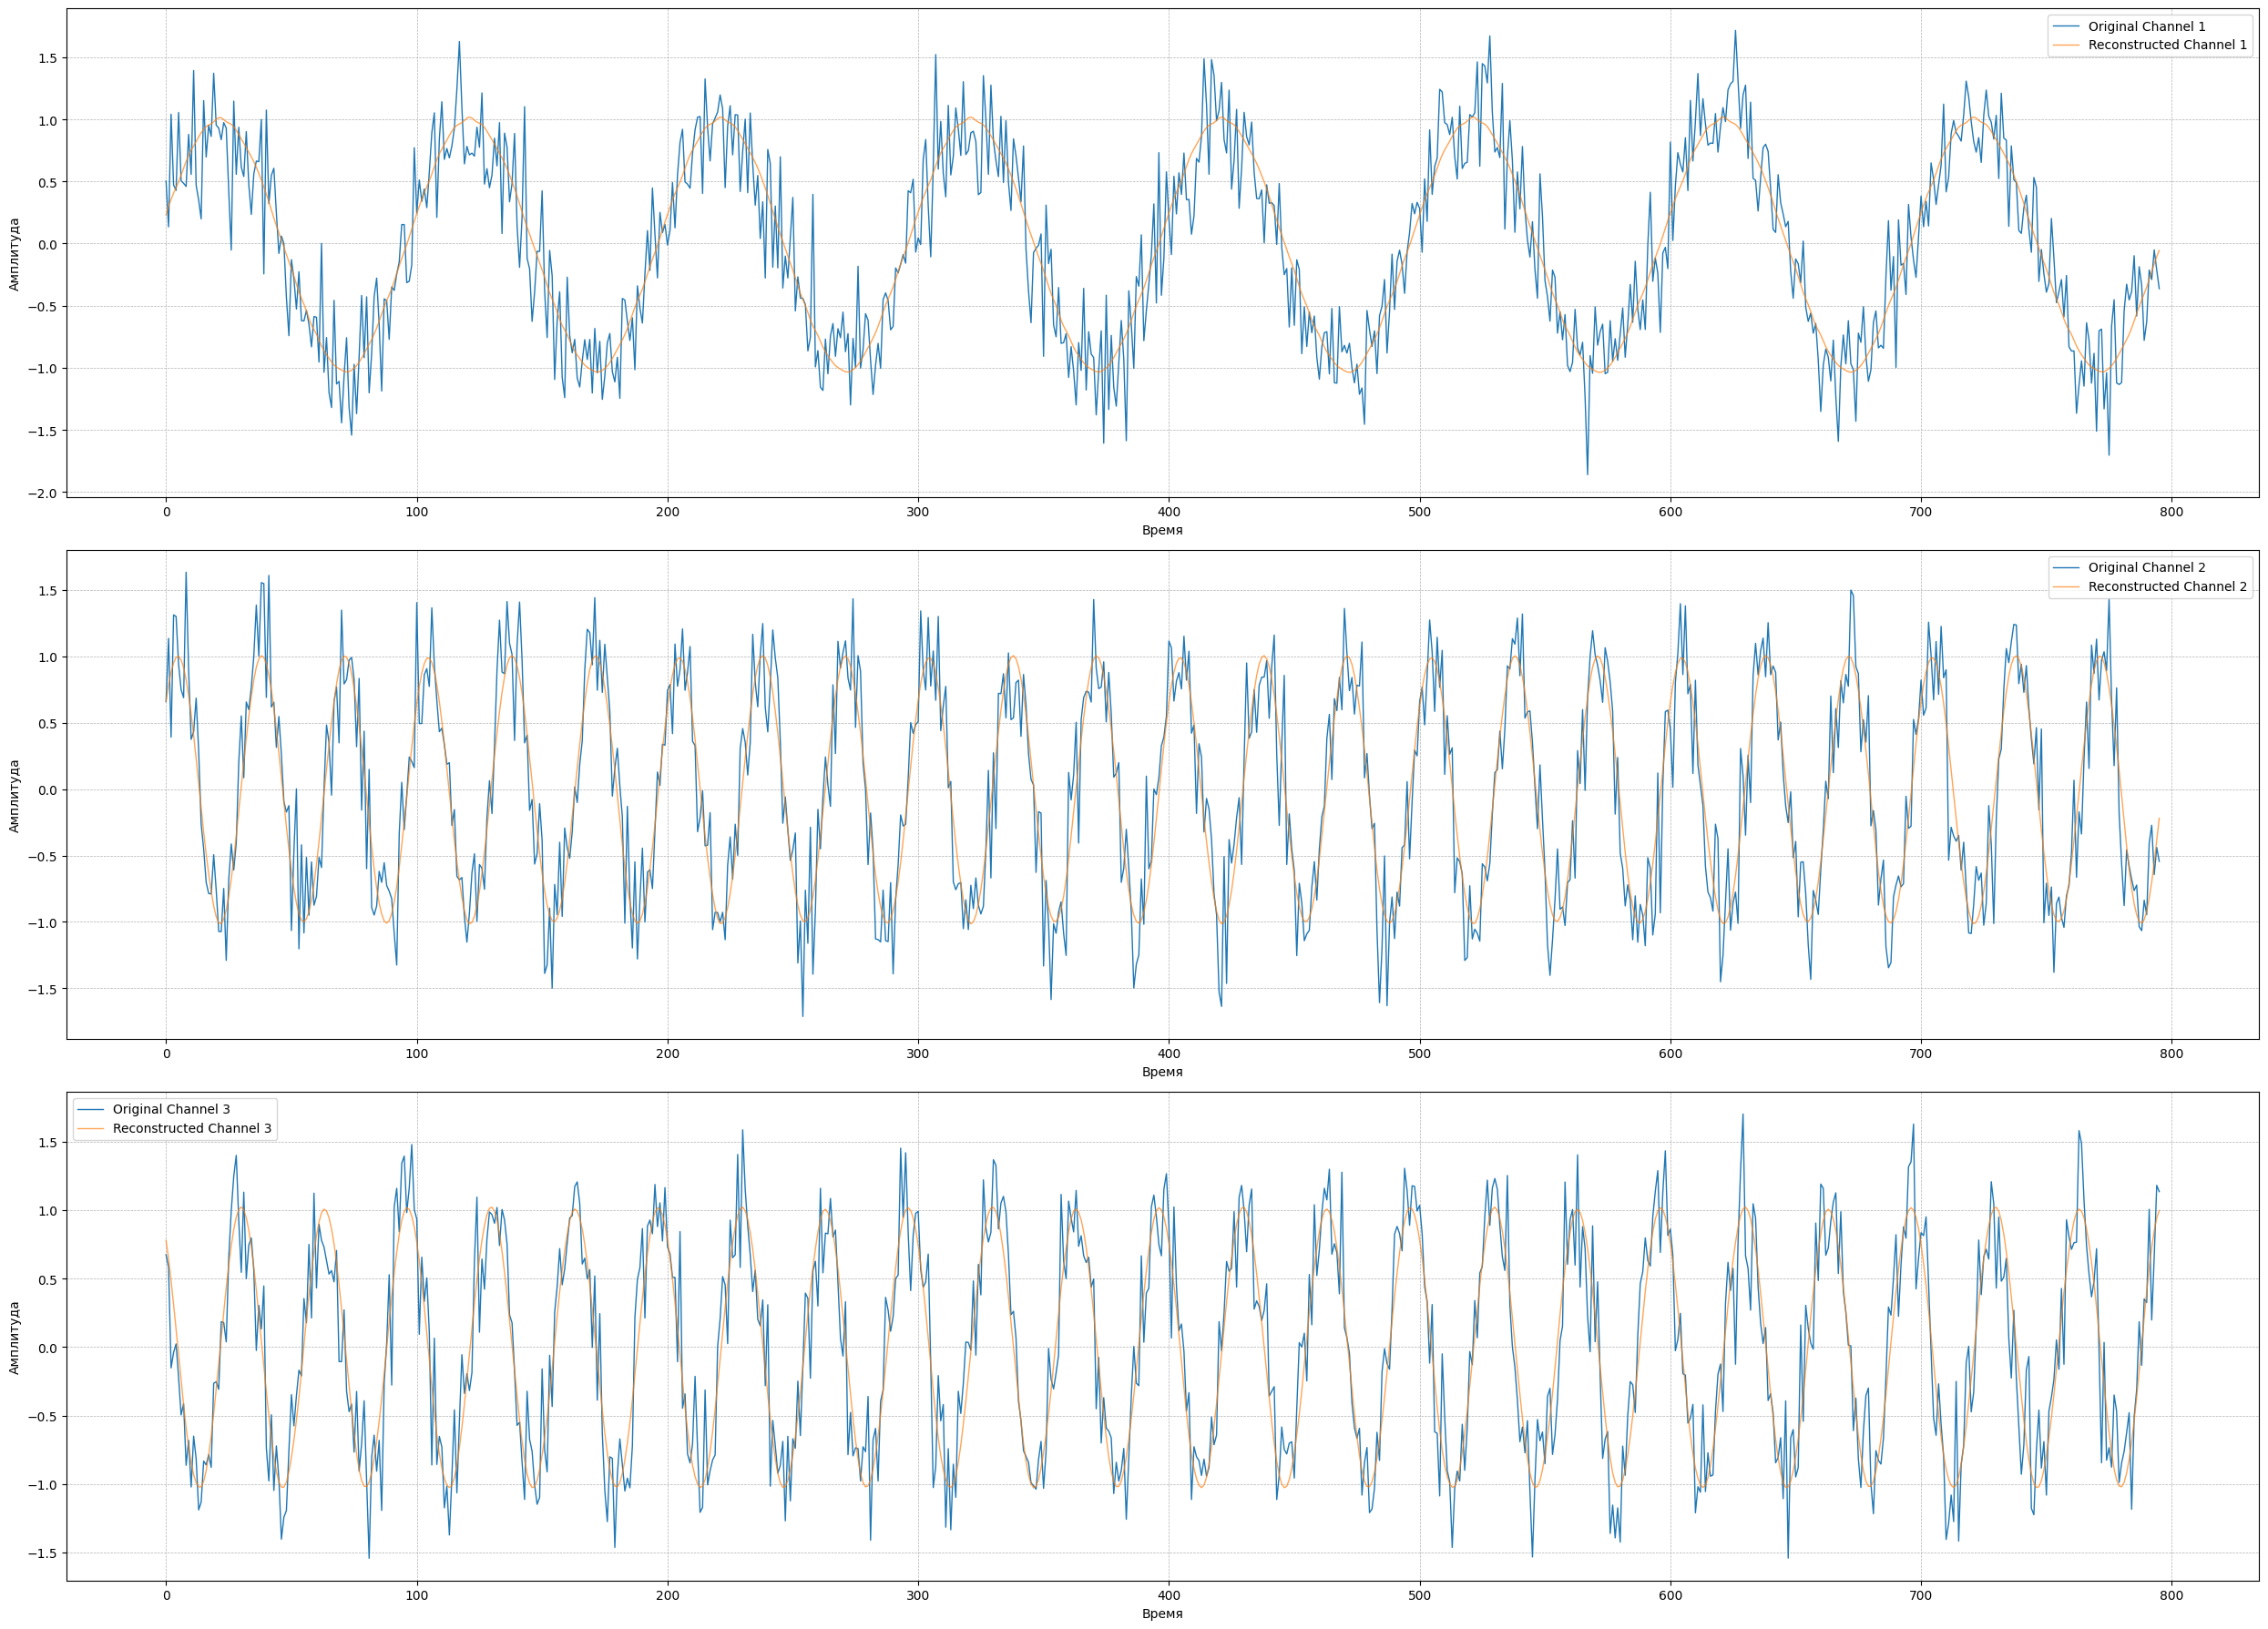

In [27]:
if len(restored_test_sequences) > 0:
    # Индекс последовательности можно выбрать по желанию
    test_index = 0
    plot_reconstruction_multivariate(test_seqs[test_index], restored_test_sequences[test_index], index=test_index)